# Enrollment Prediction - Gradient Boosting & Propensity Scoring

### Goals

* Identify the effect of scholarship amounts on a student's decision to enroll at the UW or not
* Use the original approach of HCRC; a binary logistic regression. 

### Process

* A. Load in data and software libraries
* B. Set the option flags for this run
* C. Feature Engineering. Create derived metrics. 
* D. Normalize, clean up, and dummy-code various factors
* E. Split into training and test sets
* F. Run a gradient boosting classification
* G. Evaluate the results for accuracy
* H. Propensity Score Modeling

### Resources

* http://blog.yhat.com/posts/logistic-regression-python-rodeo.html 
* http://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
* http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/
* https://www.r-bloggers.com/how-to-perform-a-logistic-regression-in-r/

## Part A: Load in data and software libraries

**Load in the software libraries**

In [1]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle

# Get data-munging libraries
from sklearn import preprocessing
from sklearn.preprocessing import Binarizer, FunctionTransformer, PolynomialFeatures
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.decomposition import PCA

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split

from imblearn.over_sampling import SMOTE 

#from tpot import TPOTClassifier

## Get propensity score libraries
from causalinference import CausalModel

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Load in the data**

In [2]:
#df = pd.read_csv('Working_Data_set.csv')
#df = pd.read_csv('working_data_set_v2.csv.zip', compression='infer')
df = pd.read_csv('working_data_set_Lavi_clean.csv')
retention_df = pd.read_csv('retention_info.csv')

In [3]:
#These are tuition amounts for each year, non-resident. 
#http://opb.washington.edu/sites/default/files/opb/Tuition/2016-17%20Tuition%20%26%20Fee%20History.pdf

df.loc[df.yr == 2010, 'Tuition'] = 25329
df.loc[df.yr == 2011, 'Tuition'] = 28058
df.loc[df.yr == 2012, 'Tuition'] = 29938
df.loc[df.yr == 2013, 'Tuition'] = 31971
df.loc[df.yr == 2014, 'Tuition'] = 33513
df.loc[df.yr == 2015, 'Tuition'] = 34143
df.loc[df.yr == 2016, 'Tuition'] = 34791

In [4]:
# Drop unneeded columns
df.drop('system_key', axis=1, inplace=True)
df.drop('GenderDesc', axis=1, inplace=True)
df.drop('EthnicityDesc', axis=1, inplace=True)
df.drop('HighSchoolCode', axis=1, inplace=True)
df.drop('yr_to_use', axis=1, inplace=True)

# Drop confounding columns
df.drop('EnrollYrQtr', axis=1, inplace=True)
df.drop('FirstYrGPA', axis=1, inplace=True)
df.drop('FirstYrCredits', axis=1, inplace=True)
df.drop('TestDesc', axis=1, inplace=True)
#df.drop('TotalBudgetRemaining', axis=1, inplace=True)
#df.drop('TuitionRemaining', axis=1, inplace=True)
#df.drop('Fisap_Income', axis=1, inplace=True)

# Dubious origin state
df.drop('OriginState', axis=1, inplace=True)

In [5]:
df_backup = df.copy(deep=True)

In [6]:
# Look at the columns in the data
df.columns

Index([u'yr', u'yr_matched', u'HighestParentalEducation',
       u'PurpleAndGoldAmount', u'IsEnrolledOrMatriculated', u'EFC',
       u'Fisap_Income', u'Grants_and_Scholarships', u'UW_Grants', u'WorkLoans',
       u'Tuition', u'TotalBudget', u'TuitionRemaining',
       u'TotalBudgetRemaining', u'HighSchoolGPA', u'TestScore',
       u'AcademicScore', u'AcademicRank', u'HolisticScore1', u'HolisticScore2',
       u'FinAidSegment', u'AcademicSegment', u'UWAttraction_TotalCount',
       u'UWAttraction_TotalPct', u'UWAttraction_ProdPct',
       u'UWLocationAttraction_TotalCount', u'UWLocationAttraction_TotalPct',
       u'UWEdGoals_TotalCount', u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct',
       u'LowerIncomePct', u'LowerIncomeCount', u'HigherIncomeCount',
       u'LowerParentEdPct', u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed'

In [7]:
df.HolisticScore2.describe()

count    75741.000000
mean         2.367495
std          2.324528
min          0.000000
25%          0.000000
50%          4.000000
75%          4.666666
max          7.000000
Name: HolisticScore2, dtype: float64

In [8]:
df.PurpleAndGoldAmount.describe()

count    75741.000000
mean      1870.565480
std       3034.932912
min          0.000000
25%          0.000000
50%          0.000000
75%       4500.000000
max      14000.000000
Name: PurpleAndGoldAmount, dtype: float64

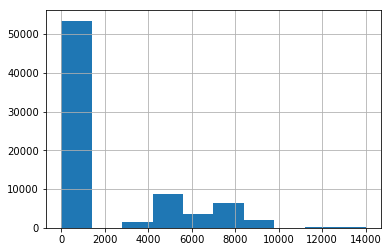

In [9]:
df.PurpleAndGoldAmount.hist()

In [10]:
df.PurpleAndGoldAmount.value_counts()

0        53458
5500      3995
7500      3908
6500      3481
5000      2532
4500      2119
8000      1387
8500      1048
7000      1019
9500      1014
4000       808
3000       679
14000      113
12000      111
9000        69
Name: PurpleAndGoldAmount, dtype: int64

## Part B - Set the option flags for this run

In [11]:
# Which years are around?
np.unique(df['yr'])

array([2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype=int64)

### Set All The Flags

1. Set the year
2. Set the number of interaction terms to use
3. Visualize or not
4. Normalize or not
5. Simple or detailed accuracy metrics

In [12]:
use_all_years = False
year = 2016

if not use_all_years:
    use_most_recent = True

use_pugo_amounts = True

show_viz = False

normalize_metrics = True

detailed_accuracy_metrics = True

f_score_analysis = False

save_results = True

run_tpot = False

stratify_split = False

model_choice = 'boosting' # options are 'boosting' and 'logit'

#### Remove entries with missing data. 

In [13]:
if use_all_years == False:
    if use_most_recent == True:
        df = df[df['yr'].isin([2016, 2015, 2014])]
    else:
        df = df.loc[df['yr'] == year]

df.drop('yr', axis=1, inplace=True)
df = df.reset_index(drop=True)

df = df[np.isfinite(df['EFC'])]

df = df.dropna(how = 'any')

df.isnull().sum()

yr_matched                         0
HighestParentalEducation           0
PurpleAndGoldAmount                0
IsEnrolledOrMatriculated           0
EFC                                0
Fisap_Income                       0
Grants_and_Scholarships            0
UW_Grants                          0
WorkLoans                          0
Tuition                            0
TotalBudget                        0
TuitionRemaining                   0
TotalBudgetRemaining               0
HighSchoolGPA                      0
TestScore                          0
AcademicScore                      0
AcademicRank                       0
HolisticScore1                     0
HolisticScore2                     0
FinAidSegment                      0
AcademicSegment                    0
UWAttraction_TotalCount            0
UWAttraction_TotalPct              0
UWAttraction_ProdPct               0
UWLocationAttraction_TotalCount    0
UWLocationAttraction_TotalPct      0
UWEdGoals_TotalCount               0
U

## Part C - Derived Features

### Part C1 - Create derived features (feature engineering)

* need_after_grants = total budgets minus grants
* need_after_grantsandincome = total budgets minus grants minus efc
* the amount a student would spend after all grants / scholarships

In [14]:
#df['need_after_grants'] = df['TotalBudget'] - df['UW_Grants'] - df['Grants_and_Scholarships']
#df['need_after_grants_efc'] = df['TotalBudget'] - df['UW_Grants'] - df['Grants_and_Scholarships'] - df['EFC']
if use_pugo_amounts:
    df['tuition_after_grants'] = df['Tuition'] - df['PurpleAndGoldAmount'] - df['Grants_and_Scholarships']
else:
    df['tuition_after_grants'] = df['Tuition'] - df['Grants_and_Scholarships']
#df['tuition_after_grants_efc'] = df['Tuition'] - df['UW_Grants'] - df['Grants_and_Scholarships'] - df['EFC']

df.loc[df.tuition_after_grants < 0, 'tuition_after_grants'] = 0

df.drop('TotalBudget', axis=1, inplace=True)
df.drop('Tuition', axis=1, inplace=True)
df.drop('UW_Grants', axis=1, inplace=True)
df.drop('Grants_and_Scholarships', axis=1, inplace=True)
df.drop('AcademicRank', axis=1, inplace=True)
purpleAndGoldAmount = df['PurpleAndGoldAmount']
df.drop('PurpleAndGoldAmount', axis=1, inplace=True)

In [15]:
df.tuition_after_grants.describe()

count    41448.000000
mean     31783.913844
std       3261.222676
min          0.000000
25%      28643.000000
50%      33513.000000
75%      34143.000000
max      34791.000000
Name: tuition_after_grants, dtype: float64

### Part C2 - Add retention info (feature engineering)

* 5-year graduation rate
* avg quarters to graduate
* avg+1 stdev quarters to graduate
* avg-1 stdev quarters to graduate

In [16]:
retention_df['5yr_grad_rate'] = retention_df['graduated_student_count'] * 1.0 / retention_df['student_count']

In [17]:
retention_df['avgplus1_quarters_to_graduate'] = retention_df['avg_quarters_to_graduate'] + retention_df['stdev_quarters_to_graduate']
retention_df['avgminus1_quarters_to_graduate'] = retention_df['avg_quarters_to_graduate'] - retention_df['stdev_quarters_to_graduate']
retention_df.ix[retention_df.avgminus1_quarters_to_graduate < 0, 'avgminus1_quarters_to_graduate'] = 0

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
retention_df.drop('graduated_student_count', axis=1, inplace=True)
retention_df.drop('student_count', axis=1, inplace=True)
retention_df.drop('stdev_quarters_to_graduate', axis=1, inplace=True)

In [19]:
#retention_df[~retention_df.applymap(np.isreal).all(1)]

In [20]:
#retention_df.first_major_category.unique()

In [21]:
df['first_major_category'] = 'Unknown'
df.ix[df.BioAndMed == 1, 'first_major_category'] = 'BioAndMed'
df.ix[df.CompSci == 1, 'first_major_category'] = 'CompSci'
df.ix[df.Business == 1, 'first_major_category'] = 'Business'
df.ix[df.Eng == 1, 'first_major_category'] = 'Eng'
df.ix[df.PsychAnthro == 1, 'first_major_category'] = 'PsychAnthro'
df.ix[df.ArtDesign == 1, 'first_major_category'] = 'ArtDesign'
df.ix[df.Law == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.IntlStudies == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.Nursing == 1, 'first_major_category'] = 'Nursing'
df.ix[df.Com == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'
df.ix[df.Math == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.PhysicsAstr == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.Environ == 1, 'first_major_category'] = 'MathAndScience'
df.ix[df.English == 1, 'first_major_category'] = 'Com, PoliSci, Law, IntlStudies'

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


In [22]:
df['LowerHighSchoolGPA'] = 0
df.ix[df.HighSchoolGPA > 3.0, 'LowerHighSchoolGPA'] = 3
df.ix[df.HighSchoolGPA > 3.4, 'LowerHighSchoolGPA'] = 3.4
df.ix[df.HighSchoolGPA > 3.6, 'LowerHighSchoolGPA'] = 3.6
df.ix[df.HighSchoolGPA > 3.8, 'LowerHighSchoolGPA'] = 3.8

In [23]:
df['UpperHighSchoolGPA'] = 3
df.ix[df.HighSchoolGPA > 3, 'UpperHighSchoolGPA'] = 3.4
df.ix[df.HighSchoolGPA > 3.4, 'UpperHighSchoolGPA'] = 3.6
df.ix[df.HighSchoolGPA > 3.6, 'UpperHighSchoolGPA'] = 3.8
df.ix[df.HighSchoolGPA > 3.8, 'UpperHighSchoolGPA'] = 4.0

In [24]:
dfr = df.merge(retention_df, how='left', on=['first_major_category','LowerHighSchoolGPA','UpperHighSchoolGPA'])

In [25]:
dfr.drop('first_major_category', axis=1, inplace=True)
print 'There are ' + str(dfr.HighSchoolGPA.count()) + ' rows'

There are 41448 rows


## Part D - Normalize, clean up, and dummy-code various factors

1. Convert Categorical Features to binary ones (dummy coding)
2. Create more derived features (feature engineering)
3. Normalize everything

### Part D3 - Normalize everything

* http://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

**Option Flags**

If 'normalize_metrics' is set, then we normalize all the features using standard scaling. Otherwise we leave them alone.

In [26]:
finaiddummy_df = pd.get_dummies(dfr['FinAidSegment'], prefix='finaid')
acaddummy_df = pd.get_dummies(dfr['AcademicSegment'], prefix='acad')
eddummy_df = pd.get_dummies(dfr['HighestParentalEducation'], prefix='ed')

eddummy_df['ed_1m'] = eddummy_df['ed_1']+eddummy_df['ed_2']+eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_2m'] = eddummy_df['ed_2']+eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_3m'] = eddummy_df['ed_3']+eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_4m'] = eddummy_df['ed_4']+eddummy_df['ed_5']+eddummy_df['ed_6']
eddummy_df['ed_5m'] = eddummy_df['ed_5']+eddummy_df['ed_6']

# Investigate fin aid dummy variables
# finaiddummy_df.head()

# Investigate academic dummy variables
# acaddummy_df.head()

# Join the binary variables to the data
df_1 = dfr.join(eddummy_df)
df_2 = df_1.join(finaiddummy_df)
df_3 = df_2.join(acaddummy_df)

df_3.drop('FinAidSegment', axis=1, inplace=True)
df_3.drop('AcademicSegment', axis=1, inplace=True)
df_3.drop('HighestParentalEducation', axis=1, inplace=True)

df_3 = df_3.reset_index(drop=True)

#df_3.head()

In [27]:
#pd.get_dummies(dfr['HighestParentalEducation'], prefix='ed')

In [28]:
df_IsEnrolled = df_3.IsEnrolledOrMatriculated.copy()

if detailed_accuracy_metrics:
    print 'df_IsEnrolled has ' + str(df_IsEnrolled.count()) + ' records, and ' + str(df_IsEnrolled.sum()) + ' are enrolled'
    print 'df3 has ' + str(df_3.TestScore.count()) + ' records'

df_IsEnrolled has 41448 records, and 5487 are enrolled
df3 has 41448 records


In [29]:
#removal of null values

drop_all_nulls = True

if drop_all_nulls:
    cols = df_3.columns[df_3.isnull().any()]
    #y = y[~x[cols].isnull().any(axis = 1)]
    #x = x[~x[cols].isnull().any(axis = 1)]
    df_3 = df_3.loc[~df_3[cols].isnull().any(axis = 1)]
    df_IsEnrolled = df_IsEnrolled.loc[df_3.index]

In [30]:
if normalize_metrics:
    #scaler = preprocessing.StandardScaler().fit(df_3)
    print 'Normalized'
    scaler = preprocessing.RobustScaler().fit(df_3) #Lavi - swapped to robust scaler
    # print out the scales so we can use them in the optimization
    #print (np.column_stack((df_3.columns, np.transpose(scaler.scale_))))
    #save off the column names
    df_3_columns = df_3.columns 
    df_4 = pd.DataFrame(scaler.transform(df_3))
    df_4.index = df_3.index
    df_4.columns = df_3_columns #re-assign the column names
    # Re-add is enrolled or matriculated to convert it back to an int
    df_4.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)
    df_5 = pd.DataFrame(df_IsEnrolled).join(df_4)
    #print 'df_4 has ',df_4.count(),' records'
else: 
    # Use this to skip the scaling step
    df_5 = df_3.copy()

Normalized


## Part E - Split into training and test sets

1. Come up with interaction terms
2. Use a 70-30 split

### Part E1 - Come up with interaction terms 

**Use PolynomialFeatures**

* Very useful - http://stackoverflow.com/questions/33257199/how-to-generate-many-interaction-terms-in-pandas
* Reference - http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html



* Complicated - http://www.dummies.com/programming/big-data/data-science/data-science-how-to-create-interactions-between-variables-with-python/
* http://patsy.readthedocs.io/en/latest/
* http://stats.idre.ucla.edu/stata/seminars/deciphering-interactions-in-logistic-regression/
* https://www.datarobot.com/blog/multiple-regression-using-statsmodels/
* http://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols

**Option Flags**

if 'full_interaction_terms' is set, then we use *all* interaction terms. Otherwise we limit ourselves to the ones only found useful when running the model in the past. - (Note that this is for previous versions. Interactions are not calculated in this version by Dev - Lavi)

In [31]:
# Create the X and Y variables
y = df_5.IsEnrolledOrMatriculated
x = df_5.copy()

x.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

if detailed_accuracy_metrics:
    print (x.columns)

Index([u'yr_matched', u'EFC', u'Fisap_Income', u'WorkLoans',
       u'TuitionRemaining', u'TotalBudgetRemaining', u'HighSchoolGPA',
       u'TestScore', u'AcademicScore', u'HolisticScore1', u'HolisticScore2',
       u'UWAttraction_TotalCount', u'UWAttraction_TotalPct',
       u'UWAttraction_ProdPct', u'UWLocationAttraction_TotalCount',
       u'UWLocationAttraction_TotalPct', u'UWEdGoals_TotalCount',
       u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct', u'LowerIncomePct',
       u'LowerIncomeCount', u'HigherIncomeCount', u'LowerParentEdPct',
       u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed', u'CompSci', u'Eng', u'Business', u'PsychAnthro',
       u'Nursing', u'Com', u'English', u'IntlStudies', u'Math', u'PhysicsAstr',
       u'Environ', u'Law', u'ArtDesign', u'DeltaParentEdMinusAcademic',
       u'DeltaAcademicMinusParen

In [32]:
squaredFeatures = False
logFeatures = False
expFeatures = False
interactionFeatures = False

In [33]:
hold = x.copy()

def scale(dfIn):
    scaler = preprocessing.RobustScaler()
    cols = dfIn.columns
    inds = dfIn.index
    output = scaler.fit_transform(dfIn)
    return pd.DataFrame(output, columns = cols, index = inds)

if squaredFeatures == True:
    interactionFeatures = False
    poly = PolynomialFeatures(2, interaction_only = False, include_bias = False)
    temp = poly.fit_transform(hold)
    x = pd.DataFrame(temp, columns = poly.get_feature_names(x.columns), index = x.index)
    x = scale(x)
if logFeatures == True:
    tempDF = hold.copy()
    tempDF[tempDF == 0] = 0.01
    temp = np.log(abs(tempDF))
    temp.columns = ['log-' + each for each in hold.columns]
    x = x.join(scale(temp))
if expFeatures == True:
    tempDF = hold.copy()
    temp = np.exp(tempDF)
    temp[temp > 10000] = 10000
    temp.columns = ['exp-' + each for each in hold.columns]
    x = x.join(scale(temp))
if interactionFeatures == True:
    poly = PolynomialFeatures(2, interaction_only = True, include_bias = False)
    temp = poly.fit_transform(hold)
    x = pd.DataFrame(temp, columns = poly.get_feature_names(x.columns), index = x.index)
    x = scale(x)
#temp = PCA(n_components = pcaComponents).fit_transform(temp)

#poly2DF = matrixToDF(temp, 'test', x.index)

In [34]:
#remove columns with all 0s
x = x.drop(x.columns[(x == 0).all()], axis = 1)

In [35]:
x.shape

(41448, 80)

In [36]:
x.tail()

yr_matched       EFC  Fisap_Income  WorkLoans  TuitionRemaining  \
41443         0.0 -0.374436     -0.305959        0.0          0.507042   
41444         0.0 -0.446841     -0.587414        0.0          0.507042   
41445         0.0 -0.448824     -0.774086        0.0          0.000000   
41446         0.0 -0.448824     -0.774086        0.0          0.507042   
41447         0.0 -0.448824     -0.567376        0.0          0.507042   

       TotalBudgetRemaining  HighSchoolGPA  TestScore  AcademicScore  \
41443              0.507042      -0.571429   0.463415      -0.394055   
41444              0.507042      -0.200000  -6.439024      -1.674924   
41445              0.000000      -0.285714   0.682927      -0.083460   
41446              0.507042       0.371429   1.195122       0.632622   
41447              0.507042       0.628571  -0.268293       0.522866   

       HolisticScore1          ...            \
41443             0.0          ...             
41444             0.0          ...             
41445             1.0          ...             
41446             0.0          ...             
41447             0.0          ...             

       finaid_FIN5 - $30K - $40K Needed  finaid_FIN6 - $40K+ Needed  \
41443                               0.0                         1.0   
41444                               0.0                         1.0   
41445                               0.0                         0.0   
41446                               0.0                         0.0   
41447                               0.0                         1.0   

       acad_ACAD1 - 1106 SAT  acad_ACAD2 - 1258 SAT  acad_ACAD3 - 1283 SAT  \
41443                    0.0                    0.0                    1.0   
41444                    1.0                    0.0                    0.0   
41445                    0.0                    0.0                    0.0   
41446                    0.0                    0.0                    0.0   
41447                    0.0                    0.0                    0.0   

       acad_ACAD4 - 1297 SAT  acad_ACAD5 - 1314 SAT  acad_ACAD6 - 1327 SAT  \
41443                    0.0                    0.0                    0.0   
41444                    0.0                    0.0                    0.0   
41445                    1.0                    0.0                    0.0   
41446                    0.0                    0.0                    0.0   
41447                    0.0                    0.0                    0.0   

       acad_ACAD7 - 1350 SAT  acad_ACAD8 - 1451 SAT  
41443                    0.0                    0.0  
41444                    0.0                    0.0  
41445                    0.0                    0.0  
41446                    0.0                    1.0  
41447                    1.0                    0.0  

[5 rows x 80 columns]

### Part E2 - Split in a 80-20 split

In [37]:
if stratify_split == True:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42, stratify=y)
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

print ('x_train has',x_train.AcademicScore.count())
print ('y_train has',y_train.count())
print ('')
print ('x_test has',x_test.AcademicScore.count())
print ('y_test has',y_test.count())

df_train = x_train.join(y_train)

#df_train.describe()
#del x, y

('x_train has', 33158)
('y_train has', 33158)

('x_test has', 8290)
('y_test has', 8290)


In [38]:
smote = False 

if smote:
    sm = SMOTE(random_state = 11)
    colX = x_train.columns
    indX = x_train.index
    colY = y_train.name
    indY = y_train.index
    x_train, y_train = sm.fit_sample(x_train, y_train)
    x_train = pd.DataFrame(x_train, columns = colX)
    y_train= pd.Series(y_train, name = colY)

In [39]:
y_train.value_counts()

0    28792
1     4366
Name: IsEnrolledOrMatriculated, dtype: int64

In [40]:
#export data and use in cross validation scripts
x_train.join(y_train).to_csv('train.csv')

## Part F - Find and run classifiers

* http://statsmodels.sourceforge.net/devel/example_formulas.html
* http://statsmodels.sourceforge.net/stable/generated/statsmodels.discrete.discrete_model.Logit.html#statsmodels.discrete.discrete_model.Logit


### Part F2 - Run models manually

**Gradient Boosting**

In [41]:
if model_choice == 'boosting':
    depth = 7 #learned from crossValidationForGradientBoostingModel script
    samplesSplit = 200
    
    ## gradient boosting
    clf = GradientBoostingClassifier(learning_rate=0.2, n_estimators=300, verbose=1,)
                                     #max_depth = depth, min_samples_split = samplesSplit) #found that 100 estimators does as well as 500
    clf.fit(x_train, y_train)
    #
    probs = clf.predict_proba(x_train)
    predicts = clf.predict(x_train)
    #
    probs_test = clf.predict_proba(x_test)
    predicts_test = clf.predict(x_test)

      Iter       Train Loss   Remaining Time 
         1           0.7300           24.82s
         2           0.7114           25.48s
         3           0.6995           25.74s
         4           0.6913           25.75s
         5           0.6857           25.61s
         6           0.6770           26.66s
         7           0.6691           27.46s
         8           0.6628           27.96s
         9           0.6572           27.97s
        10           0.6519           28.13s
        20           0.6311           26.40s
        30           0.6205           24.95s
        40           0.6109           24.62s
        50           0.6031           23.76s
        60           0.5979           22.41s
        70           0.5921           21.38s
        80           0.5864           20.41s
        90           0.5814           19.53s
       100           0.5770           18.41s
       200           0.5363            9.07s
       300           0.5037            0.00s


In [42]:
#if model_choice == 'boosting':
fi = enumerate(clf.feature_importances_)
cols = x_train.columns
sorted([(value*100, cols[i]) for (i,value) in fi if value > 0.001], reverse=True)[:100]

[(5.3514945799274143, 'EFC'),
 (5.0399424356568412, 'AcademicScore'),
 (4.9238172558078972, 'Fisap_Income'),
 (4.6527488365934806, 'UWLocationAttraction_TotalPct'),
 (4.0158943220031933, 'TestScore'),
 (3.8766409374870356, 'CollegeLocationPct_BorderState'),
 (3.6916979161381063, 'UWAttraction_TotalPct'),
 (3.1158657730327262, 'FirstGenerationPct_Not1stGen'),
 (2.8587389619418073, 'DeltaParentEdMinusAcademic'),
 (2.8566960843851121, 'LowerIncomeCount'),
 (2.8104425788439693, 'FamilyIncomePct_140to200K'),
 (2.7698600362218126, 'LowerIncomePct'),
 (2.5133076292165377, 'UWEdGoals_ProdPct'),
 (2.5125819300912107, 'DeltaAcademicMinusIncome'),
 (2.5103309752013994, 'HolisticScore1'),
 (2.4899608095252557, 'DeltaIncomeMinusAcademic'),
 (2.4739742035425984, 'UWLocationAttraction_TotalCount'),
 (2.3057757312376768, 'ParentEducationPct_NoResponse'),
 (2.2177865333145332, 'LowerParentEdPct'),
 (2.1413998364802342, 'DeltaAcademicMinusParentEd'),
 (2.0655179239187005, 'HigherIncomeCount'),
 (2.04008

## Part G - Evaluate the results for accuracy

1. Look at the logit accuracy scores
2. Look at the ROC/AUC scores
3. Look at the initial confusion matrix
4. Optimize for F scores
5. Look at feature importance


**Good Resources**

* https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb
* http://blog.yhat.com/posts/logistic-regression-and-python.html

### Part G1 - look at the accuracy scores lift

In [43]:
if detailed_accuracy_metrics:
    print ('Baseline training accuracy is', 1.0-y_train.mean())
    # Baseline accuracy is 85.48%
    print ('Training score for',model_choice,'is', clf.score(x_train, y_train))
    # 0.75451707501655474 after class_weight = 'balanced. A bad idea
    # BAD IDEA - 0.88080597862075494 use 'sag' solver. Don't do that
    print ('Improvement above the training baseline is',(clf.score(x_train, y_train)) - (1.0-y_train.mean()))
    print ('Percent improvement above the training baseline is',((clf.score(x_train, y_train)) - (1.0-y_train.mean())) / y_train.mean())

('Baseline training accuracy is', 0.8683274021352313)
('Training score for', 'boosting', 'is', 0.90554315700585075)
('Improvement above the training baseline is', 0.037215754870619455)
('Percent improvement above the training baseline is', 0.28263857077416399)


In [44]:
# Baseline accuracy
print ('Baseline test accuracy is', 1.0-y_test.mean())
# Baseline accuracy is 85.48%

print ('Test score for',model_choice,'is', clf.score(x_test, y_test))

print ('Improvement above the test baseline is',(clf.score(x_test, y_test)) - (1.0-y_test.mean()))
print ('Percent improvement above the test baseline is',((clf.score(x_test, y_test)) - (1.0-y_test.mean())) / y_test.mean())

('Baseline test accuracy is', 0.8647768395657418)
('Test score for', 'boosting', 'is', 0.88468033775633292)
('Improvement above the test baseline is', 0.019903498190591118)
('Percent improvement above the test baseline is', 0.14719000892060694)


### Part G2 - Look at the ROC/AUC scores

In [45]:
if detailed_accuracy_metrics:
    # generate evaluation metrics
    print 'Training Set AUC: ' + str(metrics.roc_auc_score(y_train, probs[:, 1]))

Training Set AUC: 0.886357345343


In [46]:
# generate evaluation metrics
print 'Test Set AUC: ' + str(metrics.roc_auc_score(y_test, probs_test[:, 1]))

Test Set AUC: 0.797188472172


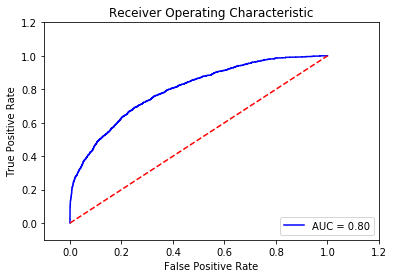

In [47]:
# Compute the FPR, TPR
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probs_test[:, 1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

# Plot an ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Part G3 - Look at the initial confusion matrix

In [48]:
def getMetrics(y_actual, y_pred, string = False):
    confusion = metrics.confusion_matrix(y_actual, y_pred)
    true_positive = confusion[1][1] # student enrolled and we predicted they would enroll
    false_positive = confusion[0][1] # student enrolled and we predicted they wouldn't enroll
    true_negative = confusion[0][0] # student didn't enroll and we predicted they wouldn't enroll
    false_negative = confusion[1][0] # student didn't enroll and we predicted they would enroll
    precision = metrics.precision_score(y_actual, y_pred)
    recall = metrics.recall_score(y_actual, y_pred)
    fscore = metrics.f1_score(y_actual, y_pred)
    output = {}
    if string:
        output = {'precision': str(precision), 
            'recall': str(recall), 
            'f_score': str(fscore), 
            'tp': str(true_positive), 
            'fp': str(false_positive), 
            'tn': str(true_negative), 
            'fn': str(false_negative)}
    else:
        output = {'precision': precision, 
            'recall': recall, 
            'f_score': fscore, 
            'tp': true_positive, 
            'fp': false_positive, 
            'tn': true_negative, 
            'fn': false_negative}
    return output

In [49]:
def generateReportString(metrics):
    output = 'Of the ' + str(metrics['tp'] + metrics['fn']) + ' students who enrolled at the UW, we correctly predicted '
    output = output + str(metrics['tp']) + ' of them.\n'
    output = output + 'Of the ' + str(metrics['tp'] + metrics['fp']) + ' students who we predicted would enroll at the UW, '
    output = output + str(metrics['tp']) + ' of them did\n'
    output = output + 'True positives: ' + str(metrics['tp']) + '; False positives: ' + str(metrics['fp']) + '\n'
    output = output + 'True negatives: ' + str(metrics['tn']) + '; False negatives: ' + str(metrics['fn']) + '\n'
    return output

In [50]:
y_array = np.array(y_train)
metricCalcs = getMetrics(y_array, predicts)

print generateReportString(metricCalcs)

Of the 4366 students who enrolled at the UW, we correctly predicted 1466 of them.
Of the 1698 students who we predicted would enroll at the UW, 1466 of them did
True positives: 1466; False positives: 232
True negatives: 28560; False negatives: 2900



In [51]:
# Now do it for the TEST set
y_array = np.array(y_test)
metricCalcs = getMetrics(y_array, predicts_test)

print generateReportString(metricCalcs)
p = metricCalcs['precision']
r = metricCalcs['recall']

Of the 1121 students who enrolled at the UW, we correctly predicted 291 of them.
Of the 417 students who we predicted would enroll at the UW, 291 of them did
True positives: 291; False positives: 126
True negatives: 7043; False negatives: 830



### Part G4 - Find the best thresholds, F-Score optimize

In [52]:
def change_cutpoint(new_threshold, probs):
    array_to_return = np.zeros(len(probs))
    for index, value in enumerate(probs):
        if value >= new_threshold:
            #print index
            array_to_return[index] = 1
    return array_to_return

In [53]:
def generateOutputString(cutoff, metrics):
    output = 'Cutoff: ' + str(cutoff) 
    output = output + '-- Precision: ' + metrics['precision'] + '; Recall: ' + metrics['recall']
    output = output + '; F-score: ' + metrics['f_score'] + '; True Pos: ' + metrics['tp'] + '; False Pos: ' + metrics['fp']
    output = output + '; True Neg: ' + metrics['tn'] + '; False Neg: ' + metrics['fn']
    return output

In [54]:
y_array = np.array(y_test)

for number in range(100):
    cutoff = number / 100.0
    new_predictions = change_cutpoint(cutoff, probs_test[:, 1])
    metricCalcs = getMetrics(y_array, new_predictions, string = True)
    print generateOutputString(cutoff, metricCalcs)

Cutoff: 0.0-- Precision: 0.135223160434; Recall: 1.0; F-score: 0.238231856338; True Pos: 1121; False Pos: 7169; True Neg: 0; False Neg: 0
Cutoff: 0.01-- Precision: 0.139595808383; Recall: 0.99821587868; F-score: 0.244938163511; True Pos: 1119; False Pos: 6897; True Neg: 272; False Neg: 2
Cutoff: 0.02-- Precision: 0.150101146325; Recall: 0.992863514719; F-score: 0.260777881912; True Pos: 1113; False Pos: 6302; True Neg: 867; False Neg: 8
Cutoff: 0.03-- Precision: 0.160458037397; Recall: 0.987511150758; F-score: 0.276059850374; True Pos: 1107; False Pos: 5792; True Neg: 1377; False Neg: 14
Cutoff: 0.04-- Precision: 0.170272812794; Recall: 0.968777876896; F-score: 0.289638618482; True Pos: 1086; False Pos: 5292; True Neg: 1877; False Neg: 35
Cutoff: 0.05-- Precision: 0.182053494392; Recall: 0.941123996432; F-score: 0.305089647195; True Pos: 1055; False Pos: 4740; True Neg: 2429; False Neg: 66
Cutoff: 0.06-- Precision: 0.195430984834; Recall: 0.908117752007; F-score: 0.321642969984; True P

Cutoff: 0.55-- Precision: 0.739247311828; Recall: 0.245316681534; F-score: 0.368385800402; True Pos: 275; False Pos: 97; True Neg: 7072; False Neg: 846
Cutoff: 0.56-- Precision: 0.742382271468; Recall: 0.239072256913; F-score: 0.361673414305; True Pos: 268; False Pos: 93; True Neg: 7076; False Neg: 853
Cutoff: 0.57-- Precision: 0.746478873239; Recall: 0.236396074933; F-score: 0.359078590786; True Pos: 265; False Pos: 90; True Neg: 7079; False Neg: 856
Cutoff: 0.58-- Precision: 0.752873563218; Recall: 0.233719892953; F-score: 0.356705241661; True Pos: 262; False Pos: 86; True Neg: 7083; False Neg: 859
Cutoff: 0.59-- Precision: 0.756676557864; Recall: 0.227475468332; F-score: 0.349794238683; True Pos: 255; False Pos: 82; True Neg: 7087; False Neg: 866
Cutoff: 0.6-- Precision: 0.757575757576; Recall: 0.223015165031; F-score: 0.344589937974; True Pos: 250; False Pos: 80; True Neg: 7089; False Neg: 871
Cutoff: 0.61-- Precision: 0.769470404984; Recall: 0.220338983051; F-score: 0.342579750347

#### Results Tracking

* Store in a Google sheet, https://docs.google.com/a/uw.edu/spreadsheets/d/1ne3dhmafyKZQNlTm7dlONYXvflGP-r3K-CeHfnOO6Qw/edit?usp=sharing 


### Part G4 - Save Everything Off

* Use pickle, https://docs.python.org/2/library/pickle.html 

In [55]:
if save_results:
    output_name = 'boosting_model.pkl'
    with open(output_name, 'wb') as output:
        pickle.dump(clf, output, pickle.HIGHEST_PROTOCOL)

In [56]:
if save_results:
    df_5.to_csv('Transformed_Data_set_v3.csv', index=False)
    print ('Saved off transformed data set')
    df_5.describe()

Saved off transformed data set


## Part H - Propensity Score Matching

### Resources

**Highly Useful Code and Guides**

* https://stats.stackexchange.com/questions/206832/matched-pairs-in-python-propensity-score-matching
* https://www.quora.com/Where-can-I-find-a-good-writeup-about-propensity-models


**Code**
* http://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb
* https://github.com/laurencium/causalinference
* https://github.com/MacHu-GWU/ctmatching-project

**Documentation/Guides**
* http://laurence-wong.com/software/


### Steps



1. Predict the probabilities (use the *entire* set)
2. Add in tuition info
3. Run through causal inference, using tuition as the effect to estimate
4. Split into buckets based on tuition_remaining. Or use stratified, which is better
    * Visualize the causal factor of each bucket


#### Part H1 - Predict the Probabilities

In [351]:
# Predict the probabilities
predictions = clf.predict_proba(x)

#sns.jointplot(x="tuition_after_grants", y="IsEnrolledOrMatriculated", data=df);

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


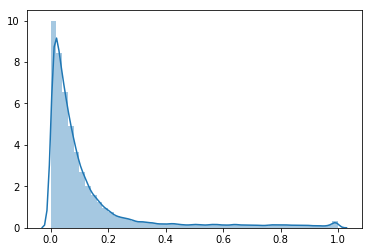

In [352]:
# Visualize the probabilities
sns.distplot(predictions[:, 1], hist=True, rug=False);

#### Part H2 - Add in tuition info

In [357]:
if use_all_years == False:
    if use_most_recent == True:
        df_tuition = df_backup.loc[df_backup['yr'].isin([2016, 2015, 2014])]
    else:
        df_tuition = df_backup.loc[df_backup['yr'] == year]
    df_tuition.reset_index(inplace=True)

else:
    df_tuition = df_backup.copy(deep=True)

In [358]:
df_tuition.loc[df_tuition.yr == 2010, 'Tuition'] = 25329
df_tuition.loc[df_tuition.yr == 2011, 'Tuition'] = 28058
df_tuition.loc[df_tuition.yr == 2012, 'Tuition'] = 29938
df_tuition.loc[df_tuition.yr == 2013, 'Tuition'] = 31971
df_tuition.loc[df_tuition.yr == 2014, 'Tuition'] = 33513
df_tuition.loc[df_tuition.yr == 2015, 'Tuition'] = 34143
df_tuition.loc[df_tuition.yr == 2016, 'Tuition'] = 34791

In [359]:
df_tuition['tuition_after_grants'] = df_tuition['Tuition'] - df_tuition['PurpleAndGoldAmount'] - df_tuition['Grants_and_Scholarships']
df_tuition.loc[df_tuition.tuition_after_grants < 0, 'tuition_after_grants'] = 0

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [360]:
df_tuition.tuition_after_grants.describe()

count    50955.000000
mean     31661.636562
std       3289.731314
min          0.000000
25%      28513.000000
50%      33513.000000
75%      34143.000000
max      34791.000000
Name: tuition_after_grants, dtype: float64

In [363]:
len(df_backup)

75741

In [361]:
len(df_tuition)

50955

In [364]:
df_tuition.drop('TotalBudget', axis=1, inplace=True)
df_tuition.drop('TotalBudgetRemaining', axis=1, inplace=True)
df_tuition.drop('Tuition', axis=1, inplace=True)
df_tuition.drop('TuitionRemaining', axis=1, inplace=True)
df_tuition.drop('WorkLoans', axis=1, inplace=True)
df_tuition.drop('UW_Grants', axis=1, inplace=True)
df_tuition.drop('Grants_and_Scholarships', axis=1, inplace=True)
df_tuition.drop('AcademicRank', axis=1, inplace=True)
#df_tuition.drop('PurpleAndGoldAmount', axis=1, inplace=True)

C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\laulck\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from th

In [365]:
df_3.columns

Index([u'yr_matched', u'IsEnrolledOrMatriculated', u'EFC', u'Fisap_Income',
       u'WorkLoans', u'TuitionRemaining', u'TotalBudgetRemaining',
       u'HighSchoolGPA', u'TestScore', u'AcademicScore', u'HolisticScore1',
       u'HolisticScore2', u'UWAttraction_TotalCount', u'UWAttraction_TotalPct',
       u'UWAttraction_ProdPct', u'UWLocationAttraction_TotalCount',
       u'UWLocationAttraction_TotalPct', u'UWEdGoals_TotalCount',
       u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct', u'LowerIncomePct',
       u'LowerIncomeCount', u'HigherIncomeCount', u'LowerParentEdPct',
       u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed', u'CompSci', u'Eng', u'Business', u'PsychAnthro',
       u'Nursing', u'Com', u'English', u'IntlStudies', u'Math', u'PhysicsAstr',
       u'Environ', u'Law', u'ArtDesign', u'DeltaParentEdMinusAcademic',
   

In [366]:
predict_df = df_3[['Fisap_Income', 'EFC', 'AcademicScore','DeltaAcademicMinusIncome', 'LowerIncomePct', 'DeltaParentEdMinusAcademic','IsEnrolledOrMatriculated']].copy(deep=True)
predict_df['PredictionScore'] = predictions[:, 1]
predict_df['TuitionRemaining'] = df_tuition.tuition_after_grants
predict_df['TuitionRemaining'] = np.round(predict_df['TuitionRemaining'] / 100)

In [368]:
predict_df['PurpleAndGoldAmount'] = purpleAndGoldAmount

In [369]:
predict_df.head()

Fisap_Income      EFC  AcademicScore  DeltaAcademicMinusIncome  \
0      232248.0  59973.0       0.881156                  0.638624   
1      250000.0  58770.0       0.878844                  0.538754   
2       20291.0      0.0       0.942781                  0.845694   
3       26191.0     94.0       0.910875                  0.852660   
4      165000.0  34850.0       0.869000                  0.559686   

   LowerIncomePct  DeltaParentEdMinusAcademic  IsEnrolledOrMatriculated  \
0        0.363799                   -0.563952                         0   
1        0.510135                   -0.432899                         1   
2        0.145631                   -0.559286                         0   
3        0.087324                   -0.530594                         0   
4        0.463972                   -0.392726                         0   

   PredictionScore  TuitionRemaining  PurpleAndGoldAmount  
0         0.077547             348.0                  0.0  
1         0.130305             335.0                  0.0  
2         0.042953             318.0               3000.0  
3         0.032164             341.0                  0.0  
4         0.052187             341.0                  0.0

In [370]:
predict_df.IsEnrolledOrMatriculated.value_counts()

0    35961
1     5487
Name: IsEnrolledOrMatriculated, dtype: int64

<Container object of 20 artists>

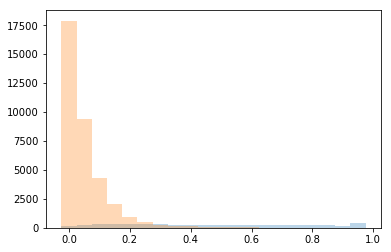

In [371]:
plt.figure()
bins = np.arange(0, 1.01, 0.05)
hist1 = np.histogram(predict_df[predict_df.IsEnrolledOrMatriculated == 1].PredictionScore, bins = bins)
hist2 = np.histogram(predict_df[predict_df.IsEnrolledOrMatriculated == 0].PredictionScore, bins = bins)
plt.bar(hist1[1][:-1], hist1[0], align = 'center', width = 0.05, alpha = 0.3)
plt.bar(hist2[1][:-1], hist2[0], align = 'center', width = 0.05, alpha = 0.3)

<Container object of 20 artists>

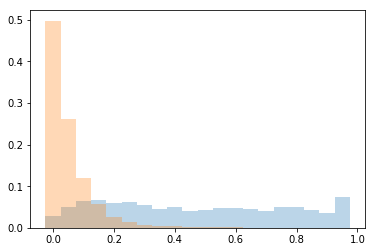

In [372]:
plt.figure()
plt.bar(hist1[1][:-1], hist1[0] / hist1[0].astype(float).sum(), align = 'center', width = 0.05, alpha = 0.3)
plt.bar(hist2[1][:-1], hist2[0] / hist2[0].astype(float).sum(), align = 'center', width = 0.05, alpha = 0.3)

In [373]:
# Split into buckets
bins = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3,0.4,0.6, 0.8, 1.0]
bin_name = [0,1,2,3,4,5,6,7,8,9]

In [374]:
predict_df['PredictionBin'] = pd.cut(predict_df['PredictionScore'], bins, labels=bin_name)

In [375]:
df_tuition.tuition_after_grants.head()

0    34791
1    33513
2    31791
3    34143
4    34143
Name: tuition_after_grants, dtype: int64

#### Use the CausalInference library
* https://github.com/laurencium/causalinference/blob/master/docs/tex/vignette.pdf

In [376]:
#causal = CausalModel(Y, D, X)
# Y 'an N-vector of observed outcomes'
# D 'an N-vector of treatment status indicators'
# X 'an N-by-K matrix of covariates'

In [377]:
predict_df.head()

Fisap_Income      EFC  AcademicScore  DeltaAcademicMinusIncome  \
0      232248.0  59973.0       0.881156                  0.638624   
1      250000.0  58770.0       0.878844                  0.538754   
2       20291.0      0.0       0.942781                  0.845694   
3       26191.0     94.0       0.910875                  0.852660   
4      165000.0  34850.0       0.869000                  0.559686   

   LowerIncomePct  DeltaParentEdMinusAcademic  IsEnrolledOrMatriculated  \
0        0.363799                   -0.563952                         0   
1        0.510135                   -0.432899                         1   
2        0.145631                   -0.559286                         0   
3        0.087324                   -0.530594                         0   
4        0.463972                   -0.392726                         0   

   PredictionScore  TuitionRemaining  PurpleAndGoldAmount PredictionBin  
0         0.077547             348.0                  0.0             1  
1         0.130305             335.0                  0.0             2  
2         0.042953             318.0               3000.0             0  
3         0.032164             341.0                  0.0             0  
4         0.052187             341.0                  0.0             1

In [378]:
predict_df.PredictionBin.value_counts()

0    18039
1     9677
2     4639
3     2428
7     1307
4     1289
9     1143
8     1109
6      977
5      840
Name: PredictionBin, dtype: int64

In [379]:
d_causal = predict_df.IsEnrolledOrMatriculated
y_causal = predict_df.PurpleAndGoldAmount

x_causal = predict_df.copy()
x_causal.drop('PredictionScore', axis=1, inplace=True)
x_causal.drop('PurpleAndGoldAmount', axis=1, inplace=True)
#x_causal.drop('TuitionRemaining', axis=1, inplace=True)
x_causal.drop('PredictionBin', axis=1, inplace=True)
x_causal.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

print (x_causal.columns)

Index([u'Fisap_Income', u'EFC', u'AcademicScore', u'DeltaAcademicMinusIncome',
       u'LowerIncomePct', u'DeltaParentEdMinusAcademic', u'TuitionRemaining'],
      dtype='object')


In [380]:
x_causal2 = x_causal.apply(pd.to_numeric, errors='ignore')

In [381]:
[x_causal2.iloc[:,i].apply(type).value_counts() for i in range(x_causal2.shape[1])]

[<type 'float'>    41448
 Name: Fisap_Income, dtype: int64, <type 'float'>    41448
 Name: EFC, dtype: int64, <type 'float'>    41448
 Name: AcademicScore, dtype: int64, <type 'float'>    41448
 Name: DeltaAcademicMinusIncome, dtype: int64, <type 'float'>    41448
 Name: LowerIncomePct, dtype: int64, <type 'float'>    41448
 Name: DeltaParentEdMinusAcademic, dtype: int64, <type 'float'>    41448
 Name: TuitionRemaining, dtype: int64]

In [382]:
causal = CausalModel(y_causal, d_causal, x_causal2.as_matrix())

In [383]:
# Summary stats
print(causal.summary_stats)


Summary Statistics

                     Controls (N_c=35961)        Treated (N_t=5487)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     2314.244     3148.726     2365.682     3164.621       51.437

                     Controls (N_c=35961)        Treated (N_t=5487)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0   163669.971   204351.535   171957.383   286976.708        0.033
             X1    46864.194    77247.395    52950.895    92334.876        0.072
             X2        0.903        0.078        0.918        0.060        0.212
             X3        0.716        0.154        0.743        0.165        0.167
             X4        0.280        0.212        0.262        0.228       -0.081
      

In [384]:
# Propensity scoring
causal.est_propensity_s()
#causal.trim_s()
print (causal.propensity)


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -6.573      0.754     -8.717      0.000     -8.051     -5.095
            X2      8.933      1.042      8.572      0.000      6.891     10.976
            X3     -3.640      1.020     -3.568      0.000     -5.640     -1.640
            X1      0.000      0.000      4.910      0.000      0.000      0.000
            X5     -0.094      0.350     -0.268      0.789     -0.779      0.592
         X3*X3      9.965      0.741     13.454      0.000      8.513     11.416
         X5*X5      2.211      0.188     11.767      0.000      1.843      2.579
         X3*X5      2.419      0.404      5.990      0.000      1.628      3.211
         X2*X3     -9.356      1.494     -6.263      0.000    -12.283     -6.428
         X2*X1     -0.000      0.000     -2.738      0.006     -0.

In [385]:
causal.propensity.keys()

['coef', 'lin', 'qua', 'loglike', 'fitted', 'se']

In [386]:
#returns an error
causal.stratify_s()
print(causal.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.002     0.089      4944       238     0.072     0.073   563.674
         2     0.089     0.091       601        47     0.090     0.090  -776.630
         3     0.091     0.093       580        68     0.092     0.092     5.544
         4     0.093     0.097      1156       139     0.095     0.095    25.193
         5     0.097     0.103      2299       291     0.100     0.100    95.200
         6     0.103     0.113      4601       580     0.108     0.108  -256.621
         7     0.113     0.123      4506       675     0.118     0.118   -56.770
         8     0.123     0.135      4532       649     0.128     0.128   143.991
         9     0.135     0.151      4442       739     0.142     0.142  -196.837
   

In [387]:
#causal.est_via_matching()
causal.est_via_ols()
causal.est_via_weighting()
#causal.est_via_blocking()
print(causal.estimates)

ValueError: On entry to DGELSD parameter number 6 had an illegal value

In [388]:
causal.stratify_s()
print(causal.strata)


Stratification Summary

              Propensity Score         Sample Size     Ave. Propensity   Outcome
   Stratum      Min.      Max.  Controls   Treated  Controls   Treated  Raw-diff
--------------------------------------------------------------------------------
         1     0.002     0.089      4944       238     0.072     0.073   563.674
         2     0.089     0.091       601        47     0.090     0.090  -776.630
         3     0.091     0.093       580        68     0.092     0.092     5.544
         4     0.093     0.097      1156       139     0.095     0.095    25.193
         5     0.097     0.103      2299       291     0.100     0.100    95.200
         6     0.103     0.113      4601       580     0.108     0.108  -256.621
         7     0.113     0.123      4506       675     0.118     0.118   -56.770
         8     0.123     0.135      4532       649     0.128     0.128   143.991
         9     0.135     0.151      4442       739     0.142     0.142  -196.837
   

In [389]:
for index, stratum in enumerate(causal.strata):
    print('Strata Number',index+1)
    stratum.est_propensity_s()
    print(stratum.propensity)

('Strata Number', 1)

Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -1.579      0.594     -2.658      0.008     -2.743     -0.415
            X1      0.000      0.000      1.532      0.125     -0.000      0.000
            X6     -0.005      0.002     -2.584      0.010     -0.009     -0.001
            X0      0.000      0.000      1.044      0.297     -0.000      0.000

('Strata Number', 2)

Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept    -17.335      4.504     -3.849      0.000    -26.162     -8.508
            X2     14.155      4.724      2.996      0.003      4.896     23.415
            X0      0.000      0.000      1.446      0.148   


Estimated Parameters of Propensity Score

                    Coef.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
     Intercept     -0.463      0.320     -1.445      0.148     -1.091      0.165
            X0     -0.000      0.000     -8.663      0.000     -0.000     -0.000
            X6     -0.001      0.001     -1.480      0.139     -0.003      0.000
            X4      1.147      0.687      1.671      0.095     -0.199      2.493
            X1      0.000      0.000      1.439      0.150     -0.000      0.000
         X0*X4      0.000      0.000      8.065      0.000      0.000      0.000
         X4*X4     -2.515      0.955     -2.633      0.008     -4.388     -0.643



In [79]:
#dir(causal.strata[0])